## Import Libraries

In [34]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-tqg_kwru
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-tqg_kwru
  Resolved https://github.com/paulgavrikov/visualkeras to commit 71e2195b7eaed364ea493568cb1c8f2916af35f2
  Preparing metadata (setup.py) ... done


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import visualkeras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [3]:
# set same seed for each model
tf.random.set_seed(42)
np.random.seed(42)

In [55]:
#from google.colab import files
#files.upload()


In [5]:
# Connect to kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
# Get necessary features from helper_functions
from useful_functions import unzip_data, walk_through_dir, plot_loss_curves

## Load Dataset

In [7]:
# Download data
!kaggle datasets download -d mohammadhossein77/brain-tumors-dataset

Dataset URL: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset
License(s): CC0-1.0
 68% 151M/221M [00:00<00:00, 1.57GB/s]
100% 221M/221M [00:00<00:00, 1.02GB/s]


In [8]:
unzip_data('/content/brain-tumors-dataset.zip')

## Create Directories

In [9]:
import os
import shutil
import random

os.mkdir('/content/Tumor')
os.mkdir('/content/Tumor/Normal')
os.mkdir('/content/Tumor/Meningioma')
os.mkdir('/content/Tumor/Glioma')
os.mkdir('/content/Tumor/Pituitary')

In [10]:
# Function to copy files from source to destination
def copy_files(src_dir, dst_dir):
    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        dst_file = os.path.join(dst_dir, filename)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
original_normal = '/content/Data/Normal'
original_glioma = '/content/Data/Tumor/glioma_tumor'
original_meningioma = '/content/Data/Tumor/meningioma_tumor'
original_pituitary = '/content/Data/Tumor/pituitary_tumor'


new_normal = '/content/Tumor/Normal'
new_meningioma = '/content/Tumor/Meningioma'
new_glioma = '/content/Tumor/Glioma'
new_pituitary = '/content/Tumor/Pituitary'

In [13]:
# Move files from original location to new location
copy_files(original_normal, new_normal)
copy_files(original_meningioma, new_meningioma)
copy_files(original_glioma, new_glioma)
copy_files(original_pituitary, new_pituitary)

In [14]:
import os
import shutil
import random

# Define the paths
data_dir = '/content/Tumor'  # Adjust this path to your actual data directory
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Create directories for train and test datasets
os.makedirs(os.path.join(train_dir, 'glioma'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'meningioma'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'pituitary'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'normal'), exist_ok=True)

os.makedirs(os.path.join(test_dir, 'glioma'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'meningioma'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'pituitary'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'normal'), exist_ok=True)

# Define the class types
class_types = {
    'glioma': os.path.join(data_dir, 'Glioma'),
    'meningioma': os.path.join(data_dir, 'Meningioma'),
    'pituitary': os.path.join(data_dir, 'Pituitary'),
    'normal': os.path.join(data_dir, 'Normal')
}

# Function to split data into train and test
def split_data(src_dir, dest_train_dir, dest_test_dir, split_ratio=0.8):
    files = os.listdir(src_dir)
    random.shuffle(files)
    split_point = int(len(files) * split_ratio)

    train_files = files[:split_point]
    test_files = files[split_point:]

    for file in train_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dest_train_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dest_test_dir, file))

# Split the data for each class
for class_name, class_dir in class_types.items():
    split_data(class_dir,
               os.path.join(train_dir, class_name),
               os.path.join(test_dir, class_name))

print("Data split into train and test directories successfully.")


Data split into train and test directories successfully.


## Data Augmentation

In [15]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory structure
train_dir = '/content/Tumor/train'
validation_dir = '/content/Tumor/test'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 17335 images belonging to 4 classes.
Found 4337 images belonging to 4 classes.


In [16]:
def multi_output_generator(generator):

  for images, labels in generator:

            # Yielding as a tuple (y, y, y) is the key
    yield images, (labels, labels, labels)

# Re-wrap your generators
train_gen_multi = multi_output_generator(train_generator)
val_gen_multi = multi_output_generator(validation_generator)

## Model Checkpoint

In [17]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, f"{model_name}.keras"),  # create filepath to save model
        verbose=0,
        save_best_only=True  # save only the best model to file
    )

In [18]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('My_Checkpoints.weights.h5',
                                                   save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                     restore_best_weights=True)

## Baseline Model

In [30]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(128, 128, 3), name='input_layer')

conv2d_0 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
max_pool_0 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_0)
conv2d_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(max_pool_0)
max_pool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_1)
conv2d_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_2)
flattened = tf.keras.layers.Flatten()(max_pool_2)
dense_0 = tf.keras.layers.Dense(128, activation='relu')(flattened)
outputs = tf.keras.layers.Dense(4, activation='softmax')(dense_0)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='baseline_model')

In [31]:
model.summary()

Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

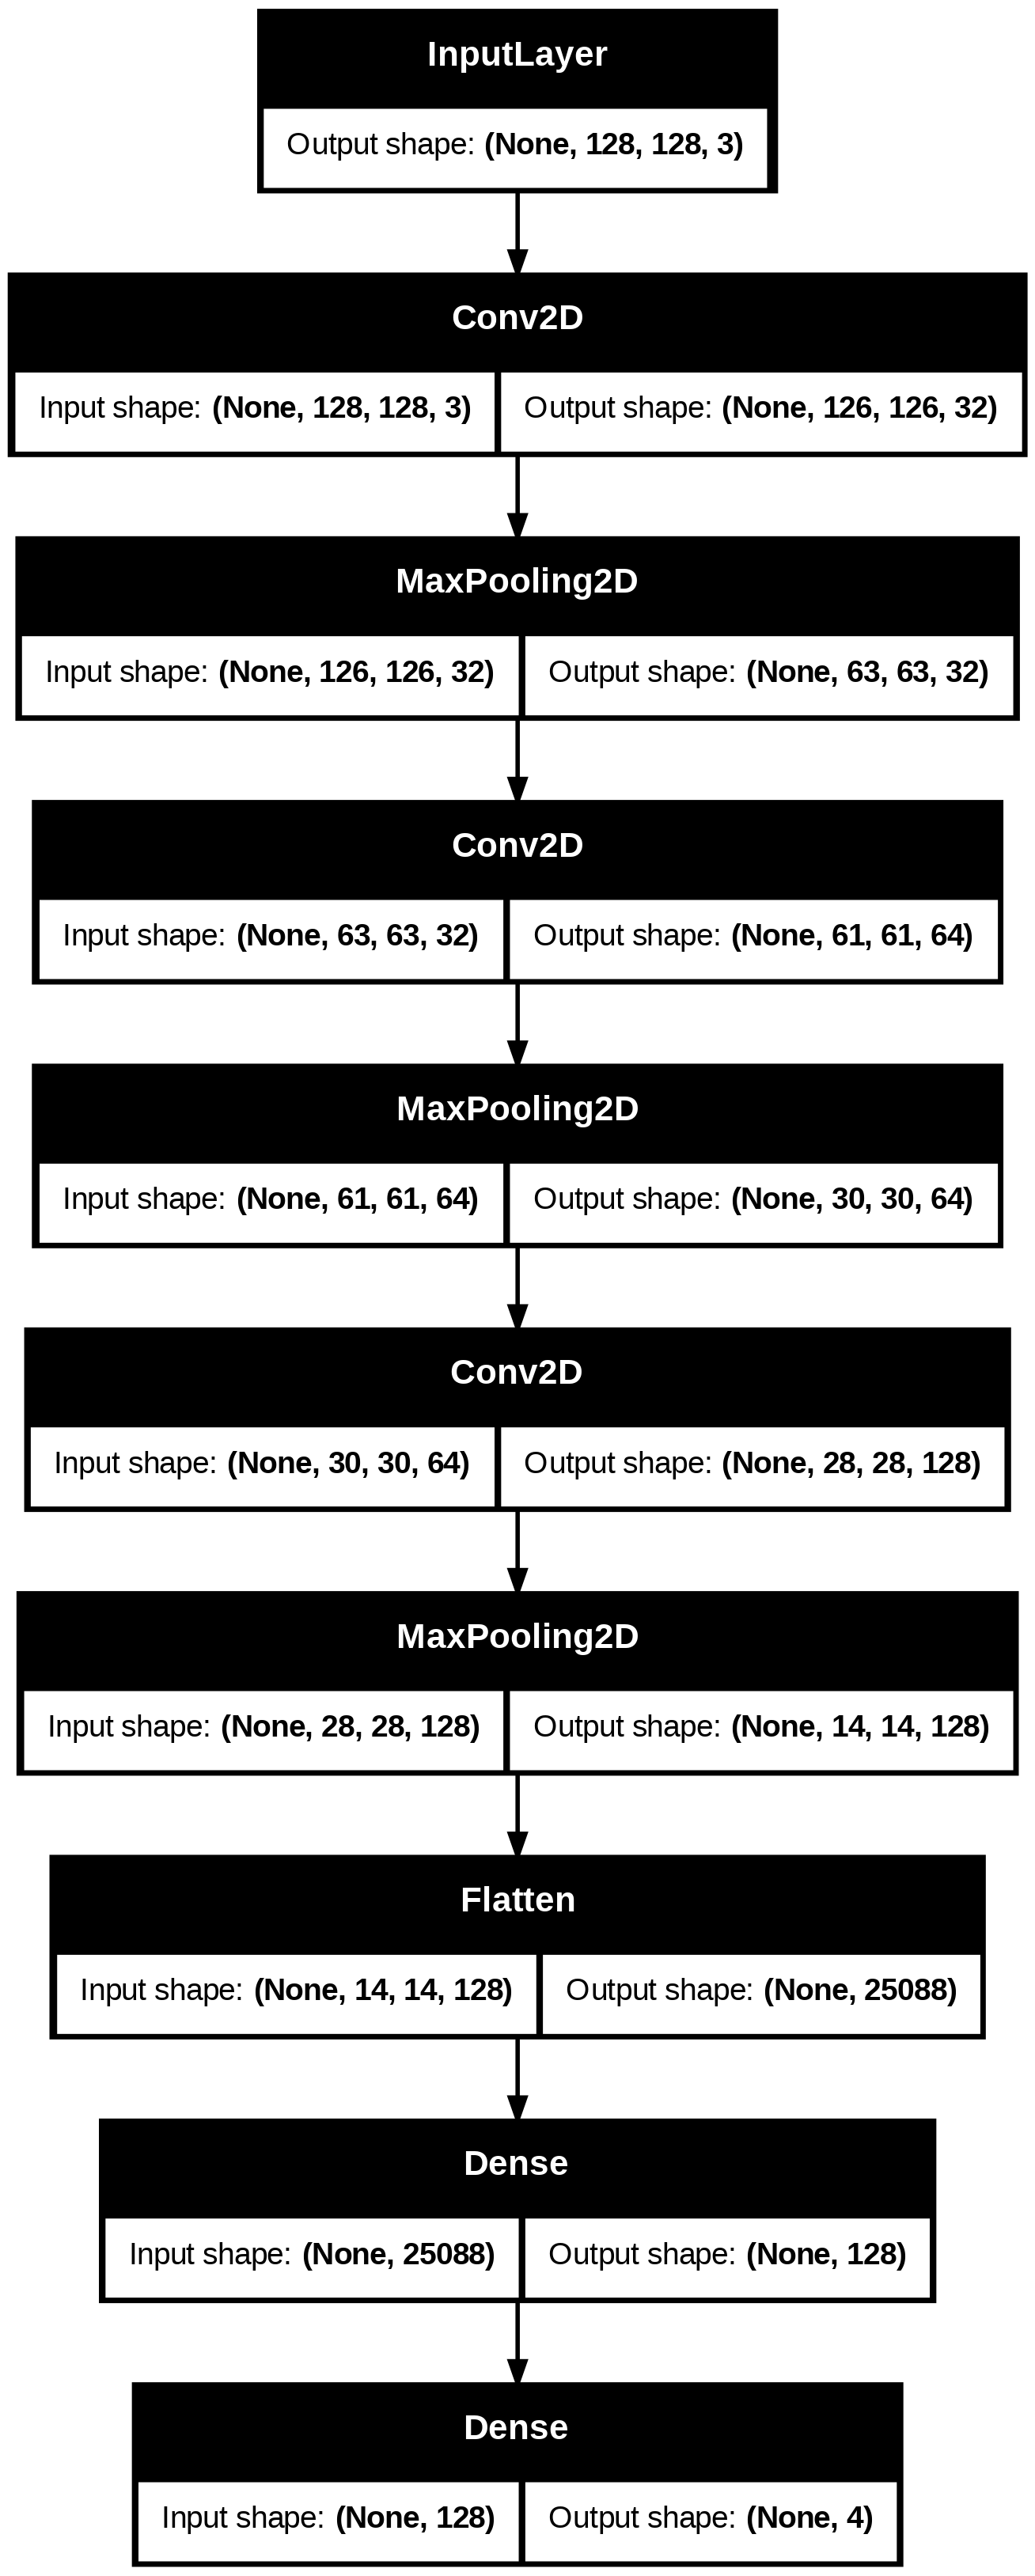

In [36]:
# Visualize model
from keras.utils import plot_model
plot_model(model, show_shapes = True)

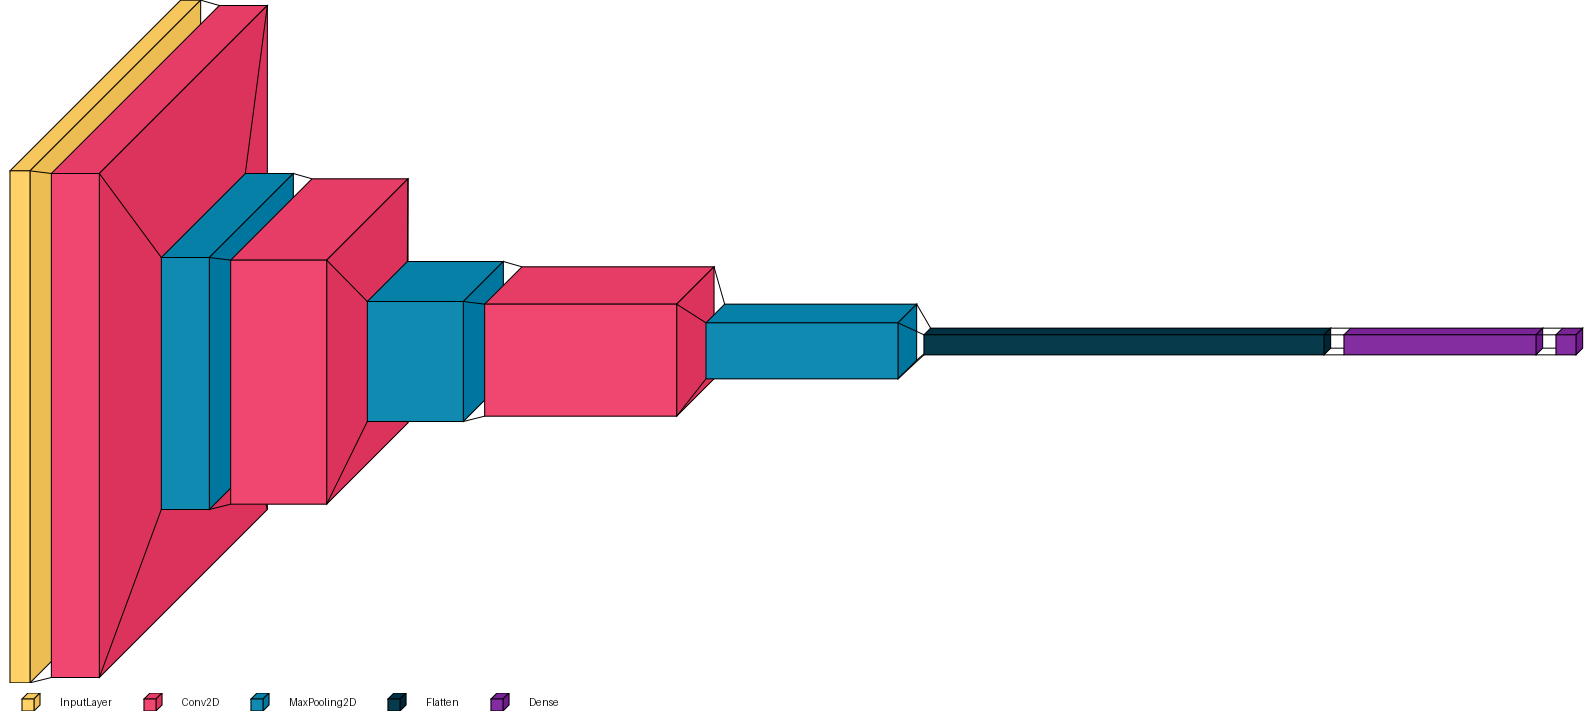

In [38]:
import visualkeras

visualkeras.layered_view(model, legend=True, draw_volume=True, spacing=20)

In [21]:
# Create Metrics

from tensorflow.keras.metrics import Precision, Recall, AUC

import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [32]:
# Compile Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        f1_score
    ]
)

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size), # Default
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / validation_generator.batch_size), # Default
    epochs=10,
    callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


542/542 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.5621 - auc: 0.8148 - f1_score: 0.4471 - loss: 1.0029 - precision: 0.6422 - recall: 0.3872 - val_accuracy: 0.7810 - val_auc: 0.9471 - val_f1_score: 0.7656 - val_loss: 0.5497 - val_precision: 0.8075 - val_recall: 0.7351
Epoch 2/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.8347 - auc: 0.9662 - f1_score: 0.8296 - loss: 0.4324 - precision: 0.8568 - recall: 0.8059 - val_accuracy: 0.8923 - val_auc: 0.9857 - val_f1_score: 0.8930 - val_loss: 0.2787 - val_precision: 0.9052 - val_recall: 0.8831
Epoch 3/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9477 - auc: 0.9953 - f1_score: 0.9485 - loss: 0.1522 - precision: 0.9526 - recall: 0.9444 - val_accuracy: 0.9373 - val_auc: 0.9920 - val_f1_score: 0.9384 - val_loss: 0.1971 - val_precision: 0.9405 - val_recall: 0.9361
Epoch 4/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.9739 - auc: 0.9990 - f1_score: 0.9741 - loss: 0.0700 - precision: 0.9757 - recall: 0.

In [35]:
model.evaluate(validation_generator)

136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9143 - auc: 0.9749 - f1_score: 0.9144 - loss: 0.4278 - precision: 0.9147 - recall: 0.9141


[0.27937549352645874,
 0.9414341449737549,
 0.9424942135810852,
 0.9409730434417725,
 0.985680103302002,
 0.9419203400611877]

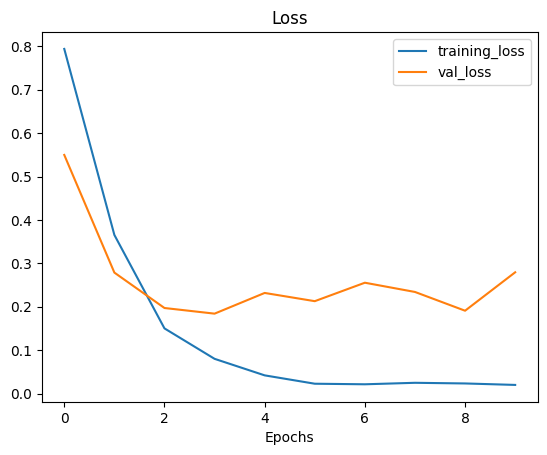

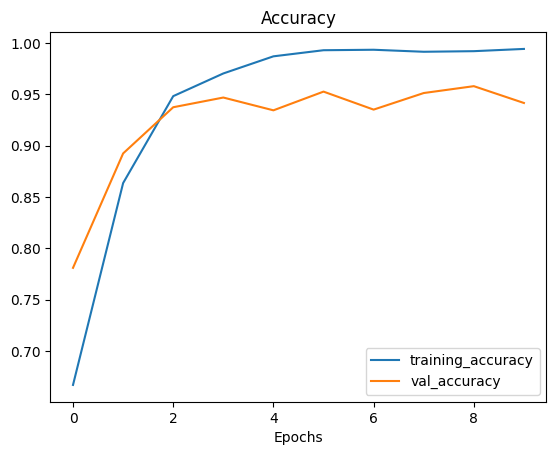

In [39]:
plot_loss_curves(history)

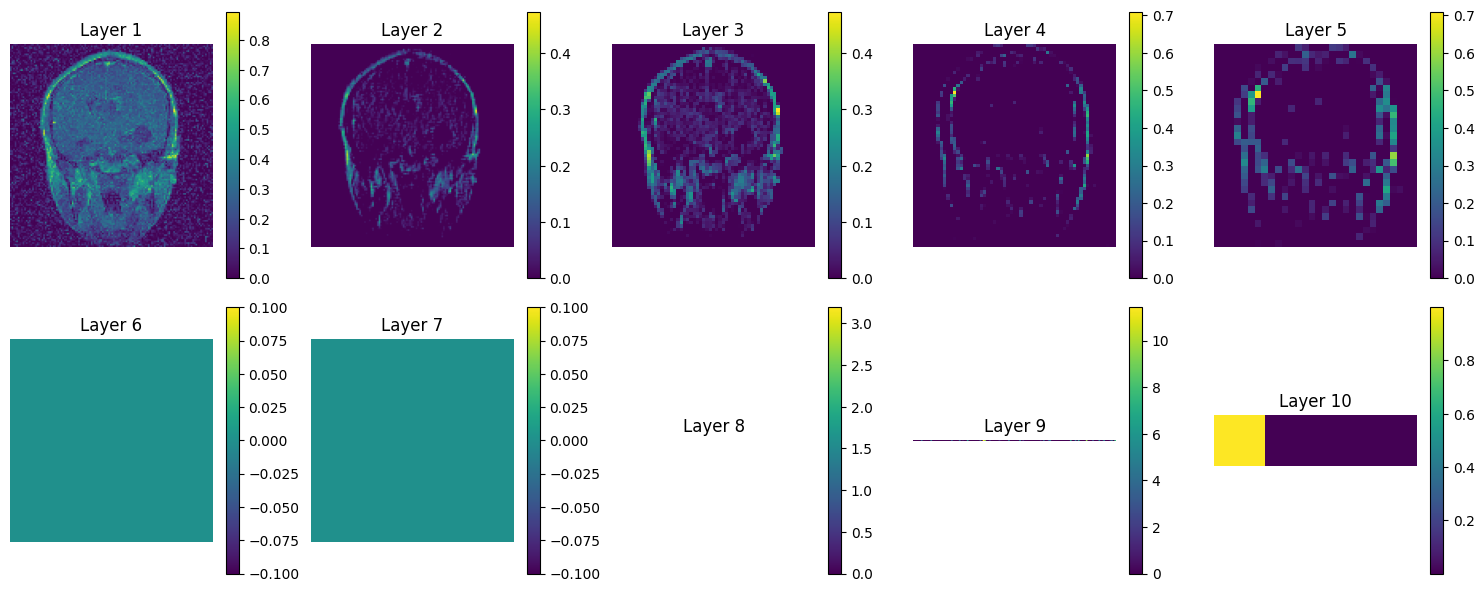

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

# Get a batch of images from the validation generator
sample_batch = next(validation_generator)
sample_image = sample_batch[0][0]  # Get the first image from the batch

# Ensure the sample image is in the correct shape
sample_image = sample_image.reshape((1, *sample_image.shape))


# Define the predict function outside the loop to avoid retracing
@tf.function
def get_intermediate_output(intermediate_model, input_data):
    return intermediate_model(input_data)

# Determine the number of layers
num_layers = len(model.layers)

# Calculate the number of rows and columns for the subplots
num_cols = 5
num_rows = (num_layers // num_cols) + (1 if num_layers % num_cols != 0 else 0)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over layers
for i in range(num_layers):
    # Get the output of the current layer
    layer_output = model.layers[i].output

    # Create a new model that will return the output of the current layer given an input
    intermediate_model = Model(inputs=model.input, outputs=layer_output)

    # Get the output of the current layer
    intermediate_output = get_intermediate_output(intermediate_model, sample_image).numpy()

    # Handle different output shapes
    if len(intermediate_output.shape) == 4:  # For Conv2D layers
        output_image = intermediate_output[0, :, :, 0]
    elif len(intermediate_output.shape) == 2:  # For Dense layers
        output_image = intermediate_output[0].reshape((1, -1))  # Reshape to 2D for visualization
    else:
        continue  # Skip layers with unsupported output shapes

    # Visualize the output using plt.imshow
    ax = axes[i]  # Get the appropriate subplot
    ax.imshow(output_image, cmap='viridis')
    ax.set_title(f'Layer {i+1}')
    ax.axis('off')
    fig.colorbar(ax.imshow(output_image, cmap='viridis'), ax=ax)

# Hide any remaining empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [43]:
def create_confusion_matrix(model):
  # Get predictions from the model
  predictions = model.predict(validation_generator)
  predicted_classes = np.argmax(predictions, axis=1)

  # Get true labels
  true_classes = validation_generator.classes
  class_labels = list(validation_generator.class_indices.keys())

  # Create confusion matrix
  cm = confusion_matrix(true_classes, predicted_classes)

  # Display confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  disp.plot(cmap='Reds', values_format='d')
  plt.title('Confusion Matrix')
  plt.show()



136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step


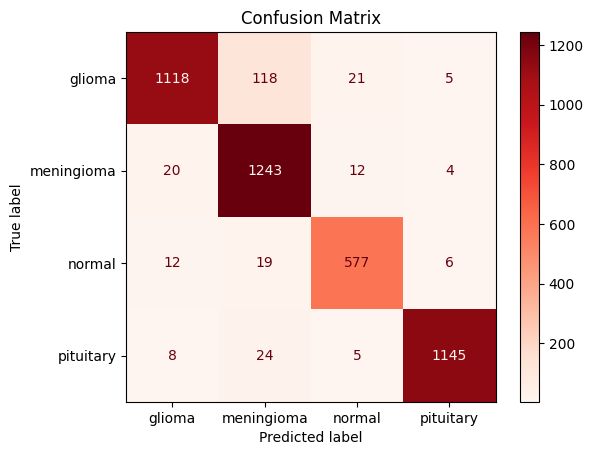

In [44]:
create_confusion_matrix(model)

## U-Net Model Implementation



Olaf Ronneberger, Philipp Fischer, Thomas Brox. "U-Net: Convolutional Networks for Biomedical Image Segmentation" (2015) https://arxiv.org/abs/1505.04597v1

In [45]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
conv2d_0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
conv2d_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_0)            # birleshdir
max_pool_0 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2d_1)
conv2d_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(max_pool_0)
conv2d_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_2)            # birleshdir
max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2d_3)
conv2d_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(max_pool_1)
conv2d_5 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_4)            # birleshdir
max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2d_5)
conv2d_6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(max_pool_2)
conv2d_7 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_6)            # birleshdir
max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2d_7)
conv2d_8 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(max_pool_3)
conv2d_9 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_8)
up_conv_0 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv2d_9)
conv2d_7 = tf.keras.layers.Resizing(
    up_conv_0.shape[1],
    up_conv_0.shape[2]
)(conv2d_7)
concat_0 = tf.keras.layers.concatenate([conv2d_7, up_conv_0], axis=3)
conv2d_10 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_0)
conv2d_11 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_10)
up_conv_1 = tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv2d_11)
conv2d_5 = tf.keras.layers.Resizing(
    up_conv_1.shape[1],
    up_conv_1.shape[2]
)(conv2d_5)
concat_1 = tf.keras.layers.concatenate([conv2d_5, up_conv_1], axis=3)
conv2d_12 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_1)
conv2d_13 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_12) #
up_conv_2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv2d_13)
conv2d_3 = tf.keras.layers.Resizing(
    up_conv_2.shape[1],
    up_conv_2.shape[2]
)(conv2d_3)
concat_2 = tf.keras.layers.concatenate([conv2d_3, up_conv_2], axis=3)
conv2d_14 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_2)
conv2d_15 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_14)
up_conv_3 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv2d_15)
conv2d_1 = tf.keras.layers.Resizing(
    up_conv_3.shape[1],
    up_conv_3.shape[2]
)(conv2d_1)
concat_3 = tf.keras.layers.concatenate([conv2d_1, up_conv_3], axis=3)
conv2d_16 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_3)
conv2d_17 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_16)
conv2d_18 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2d_17)
flattened = tf.keras.layers.Flatten()(conv2d_18)
dense_0 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(flattened)
outputs = tf.keras.layers.Dense(4, activation='softmax')(dense_0)
model_unet = tf.keras.Model(inputs, outputs, name='Unet-remake')

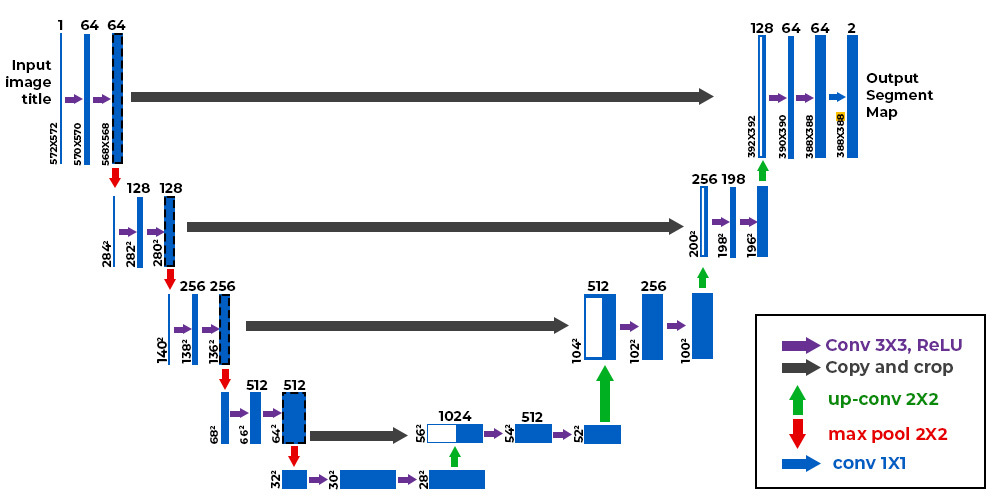

In [46]:
model_unet.summary()

Model: "Unet-remake"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  1,049,088 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 79,492,900 (303.24 MB)

 Trainable params: 79,492,900 (303.24 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
from keras.utils import plot_model

plot_model(model_unet, show_shapes = True)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:359: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


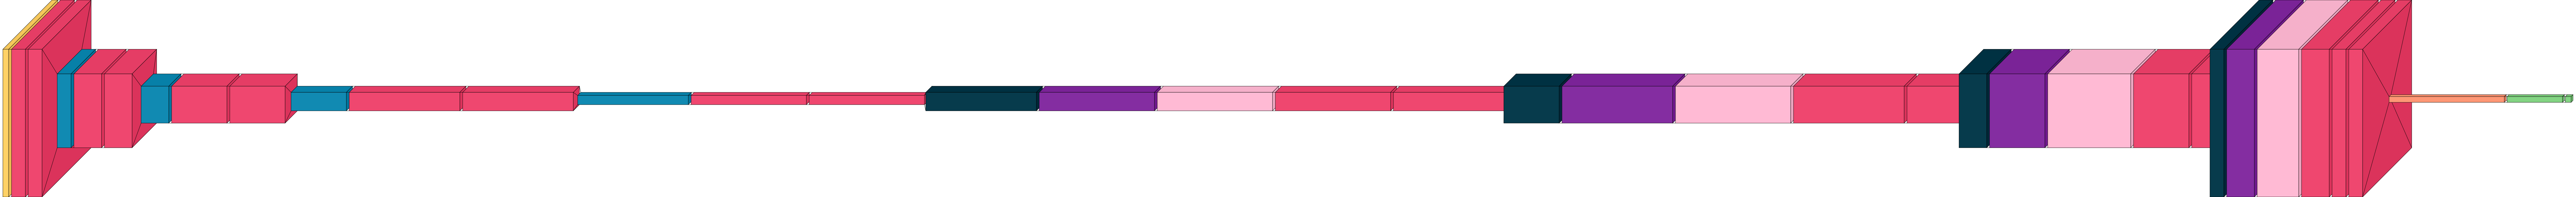

In [48]:
visualkeras.layered_view(model_unet)

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

model_unet.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        f1_score
    ]
)

In [50]:
model_unet_history = model_unet.fit(train_generator,
                                    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
                                    validation_data=validation_generator,
                                    validation_steps=math.ceil(validation_generator.samples / validation_generator.batch_size),
                                    epochs=10,
                                    callbacks=[checkpoint_cb, early_stopping_cb, create_model_checkpoint(model_name=model_unet.name)])

Epoch 1/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 272s 416ms/step - accuracy: 0.5728 - auc: 0.8063 - f1_score: 0.4667 - loss: 2.8894 - precision: 0.6403 - recall: 0.4043 - val_accuracy: 0.8294 - val_auc: 0.9662 - val_f1_score: 0.8264 - val_loss: 0.4430 - val_precision: 0.8561 - val_recall: 0.8008
Epoch 2/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 188s 347ms/step - accuracy: 0.9101 - auc: 0.9873 - f1_score: 0.9096 - loss: 0.2597 - precision: 0.9191 - recall: 0.9006 - val_accuracy: 0.8999 - val_auc: 0.9837 - val_f1_score: 0.9012 - val_loss: 0.2901 - val_precision: 0.9086 - val_recall: 0.8937
Epoch 3/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 176s 325ms/step - accuracy: 0.9828 - auc: 0.9992 - f1_score: 0.9827 - loss: 0.0569 - precision: 0.9836 - recall: 0.9818 - val_accuracy: 0.9034 - val_auc: 0.9794 - val_f1_score: 0.9046 - val_loss: 0.3714 - val_precision: 0.9056 - val_recall: 0.9029
Epoch 4/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 176s 325ms/step - accuracy: 0.9910 - auc: 0.9994 - f1_score: 0.9910 - loss: 0.0313 - precision: 

In [51]:
model_unet.evaluate(validation_generator)

136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.9018 - auc: 0.9843 - f1_score: 0.9026 - loss: 0.2795 - precision: 0.9102 - recall: 0.8956


[0.2900635302066803,
 0.8999308347702026,
 0.9085794687271118,
 0.8937053084373474,
 0.9836866855621338,
 0.9012014269828796]

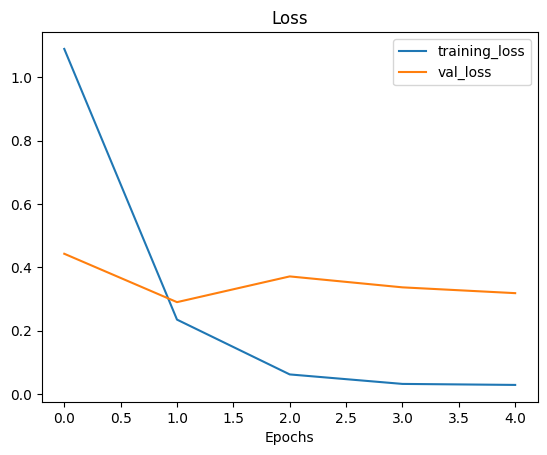

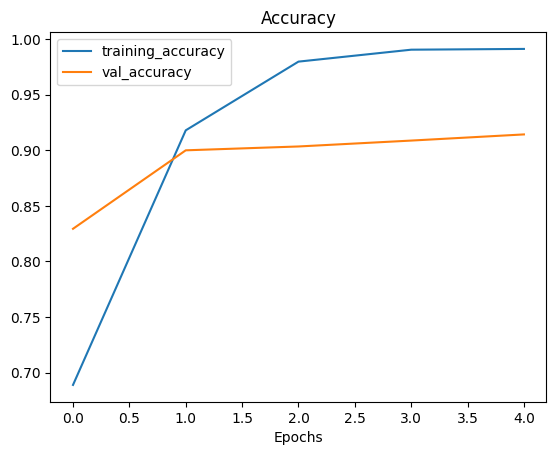

In [52]:
plot_loss_curves(model_unet_history)

136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step


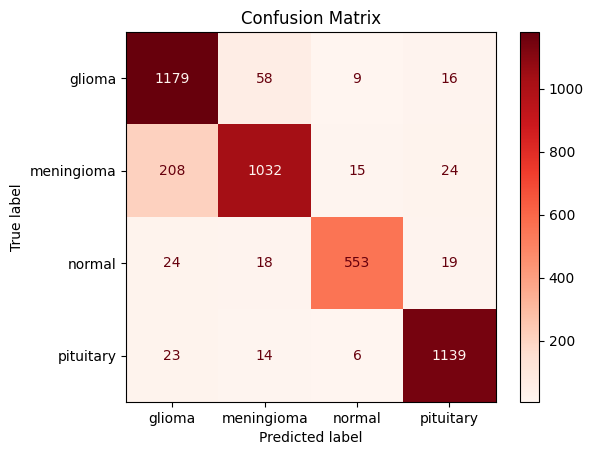

In [53]:
create_confusion_matrix(model_unet)

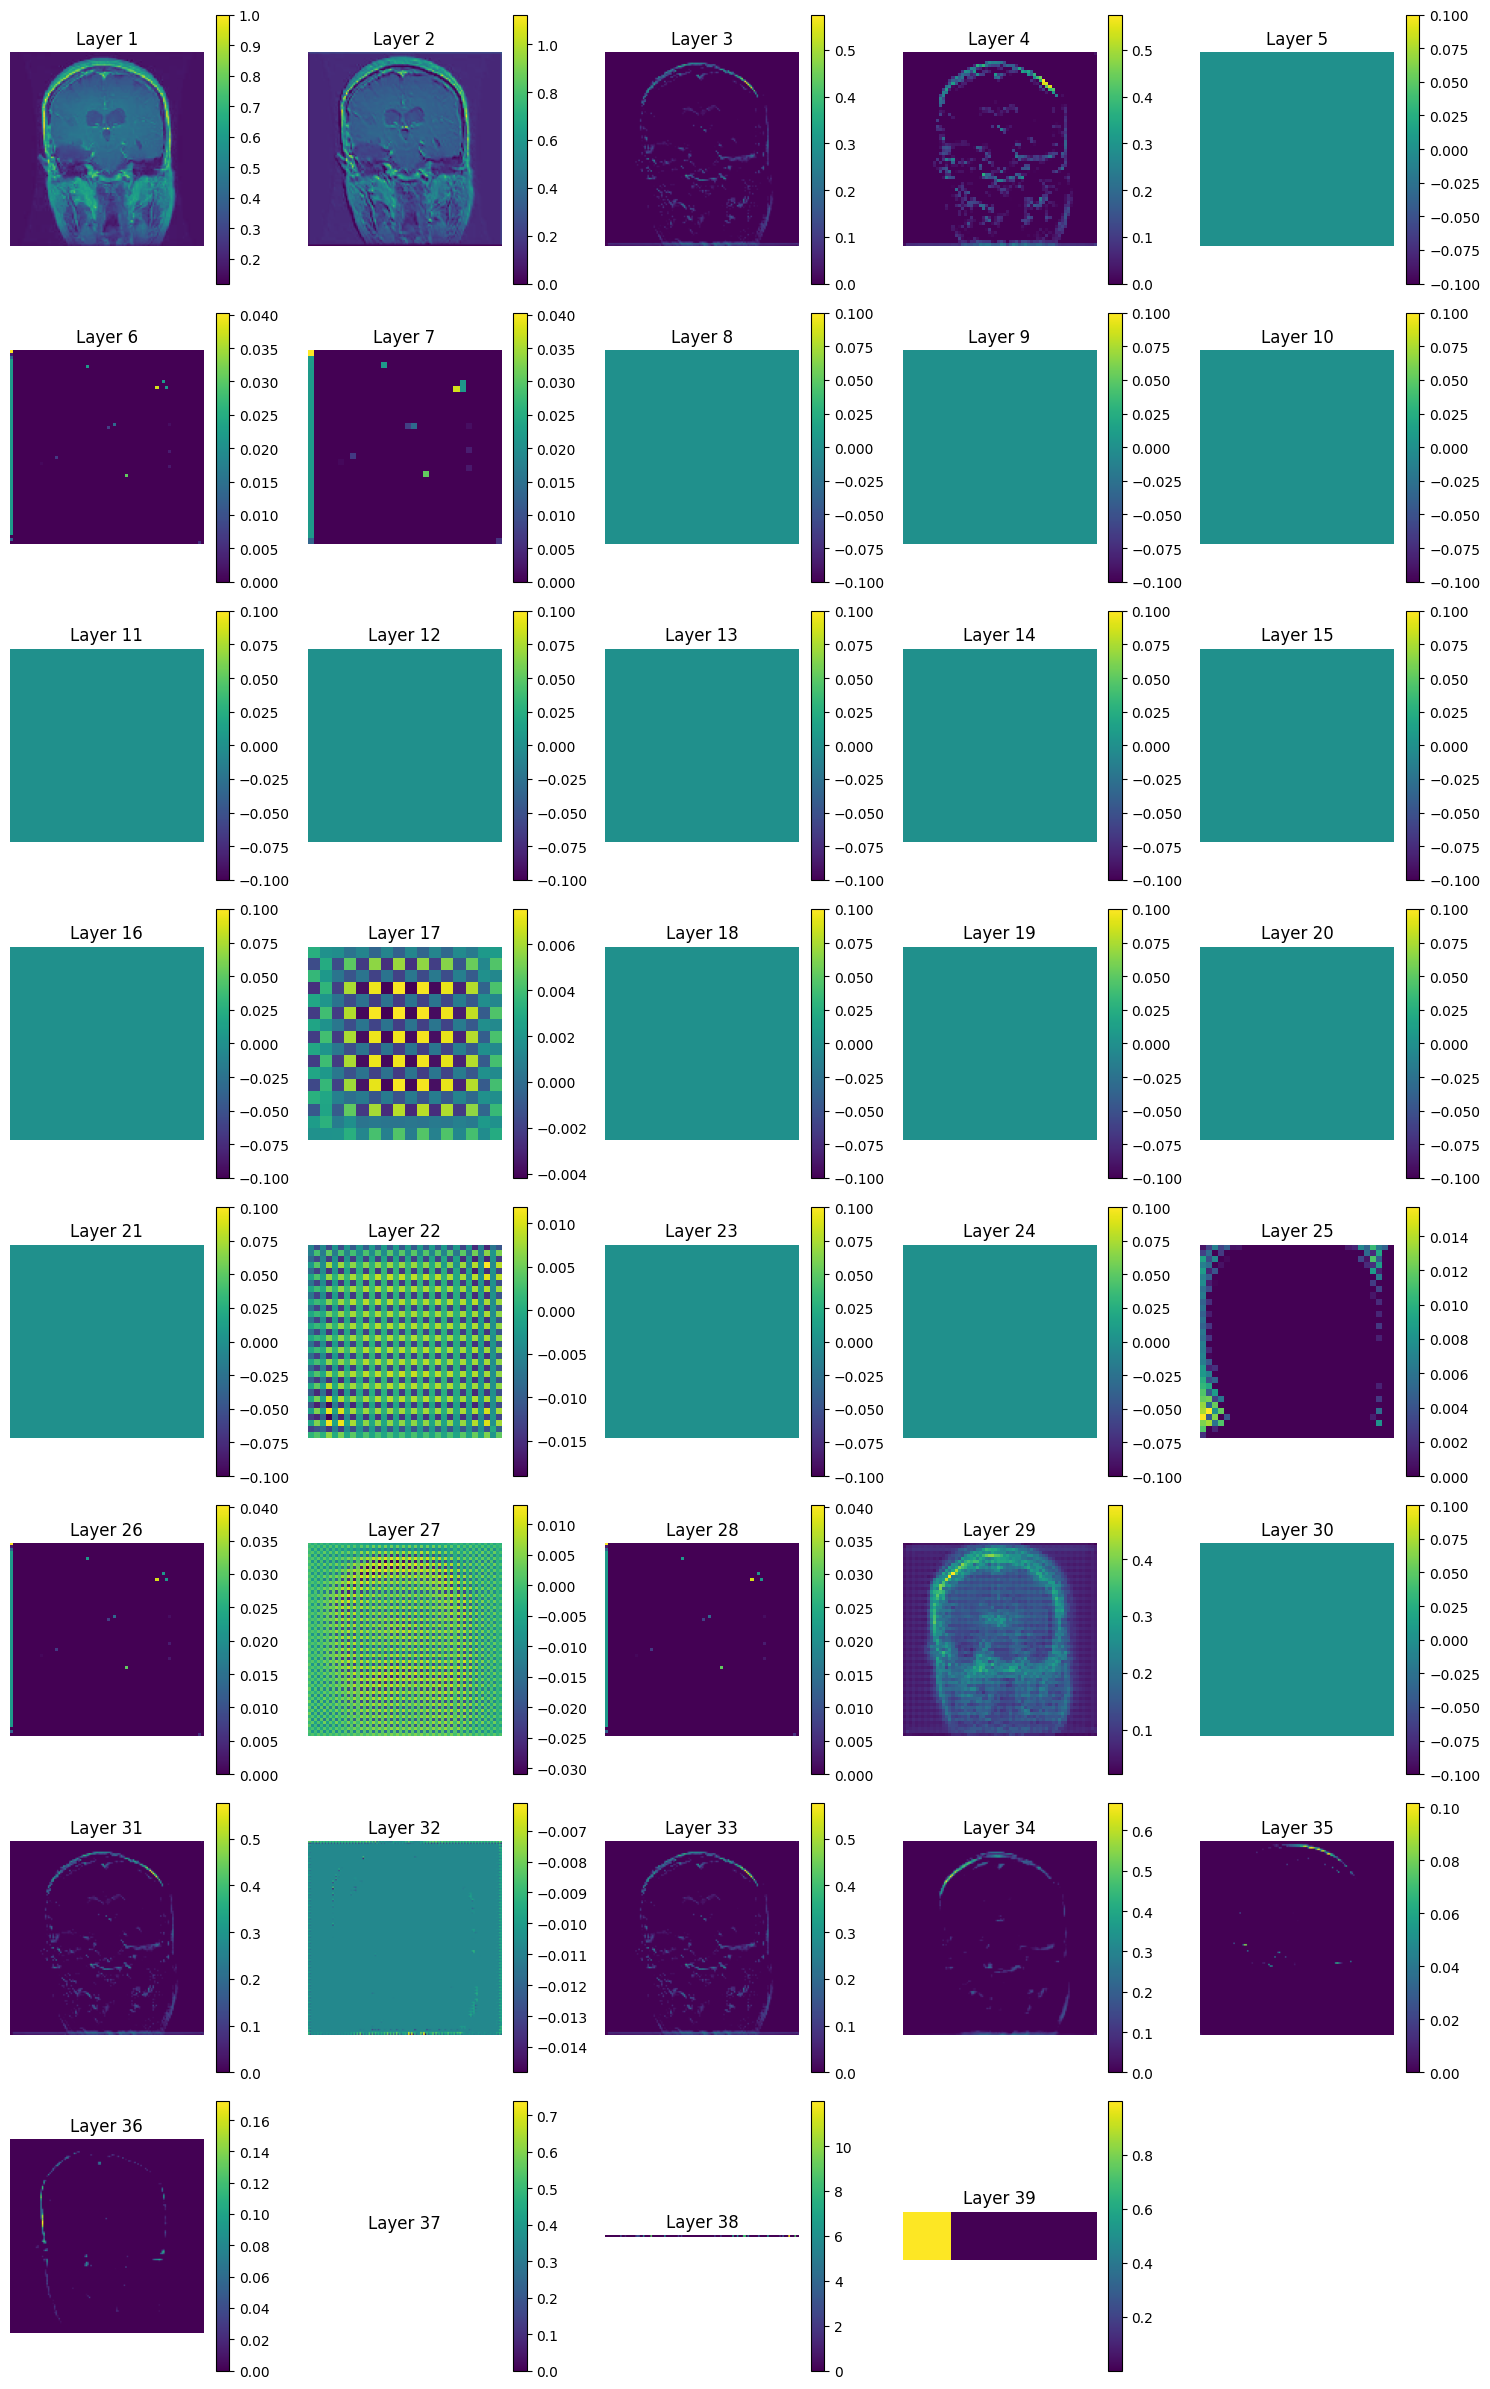

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

# Get a batch of images from the validation generator
sample_batch = next(validation_generator)
sample_image = sample_batch[0][0]  # Get the first image from the batch

# Ensure the sample image is in the correct shape
sample_image = sample_image.reshape((1, *sample_image.shape))

# Define the predict function outside the loop to avoid retracing
@tf.function
def get_intermediate_output(intermediate_model, input_data):
    return intermediate_model(input_data)

# Determine the number of layers
num_layers = len(model_unet.layers)

# Calculate the number of rows and columns for the subplots
num_cols = 5
num_rows = (num_layers // num_cols) + (1 if num_layers % num_cols != 0 else 0)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over layers
for i in range(num_layers):
    # Get the output of the current layer
    layer_output = model_unet.layers[i].output

    # Create a new model that will return the output of the current layer given an input
    intermediate_model = Model(inputs=model_unet.input, outputs=layer_output)

    # Get the output of the current layer
    intermediate_output = get_intermediate_output(intermediate_model, sample_image).numpy()

    # Handle different output shapes
    if len(intermediate_output.shape) == 4:  # For Conv2D layers
        output_image = intermediate_output[0, :, :, 0]
    elif len(intermediate_output.shape) == 2:  # For Dense layers
        output_image = intermediate_output[0].reshape((1, -1))  # Reshape to 2D for visualization
    else:
        continue  # Skip layers with unsupported output shapes

    # Visualize the output using plt.imshow
    ax = axes[i]  # Get the appropriate subplot
    ax.imshow(output_image, cmap='viridis')
    ax.set_title(f'Layer {i+1}')
    ax.axis('off')
    fig.colorbar(ax.imshow(output_image, cmap='viridis'), ax=ax)

# Hide any remaining empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Inception Model

Christian Szegedy, et al. "Going Deeper with Convolutions" (2015) https://arxiv.org/abs/1409.4842

In [19]:
import tensorflow as tf

def inception(layer, oxo, txt_red, txt, fxf_red, fxf, oxo_sec):
    conv1_1 = tf.keras.layers.Conv2D(oxo, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(layer)

    conv3_3_red = tf.keras.layers.Conv2D(txt_red, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(layer)
    conv3_3 = tf.keras.layers.Conv2D(txt, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(conv3_3_red)

    conv5_5_red = tf.keras.layers.Conv2D(fxf_red, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(layer)
    conv5_5 = tf.keras.layers.Conv2D(fxf, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(conv5_5_red)

    max_pool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(layer)
    conv1_1_sec = tf.keras.layers.Conv2D(oxo_sec, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(max_pool)

    final_layer = tf.keras.layers.Concatenate(axis=-1)([conv1_1, conv3_3, conv5_5, conv1_1_sec])
    return final_layer

tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input(shape=(128, 128, 3))

conv0 = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
max_pool0 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(conv0)
norm0 = tf.keras.layers.BatchNormalization()(max_pool0)

conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, activation='relu', kernel_initializer='he_normal', padding='valid')(norm0)
conv2 = tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), strides=1, activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
norm1 = tf.keras.layers.BatchNormalization()(conv2)
max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(norm1)

inception_0 = inception(max_pool1, 64, 96, 128, 16, 32, 32)
inception_1 = inception(inception_0, 128, 128, 192, 32, 96, 64)
max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(inception_1)
inception_2 = inception(max_pool2, 192, 96, 208, 16, 48, 64)      # avgpooling
avg_pool0 =  tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=3, padding='valid')(inception_2)
soft_conv0 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(avg_pool0)
flatten0 = tf.keras.layers.Flatten()(soft_conv0)
fc0 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(flatten0)
side_output0 = tf.keras.layers.Dense(4, activation='softmax', name='aux_0')(fc0)


inception_3 = inception(inception_2, 160, 112, 224, 24, 64, 64)
inception_4 = inception(inception_3, 128, 128, 256, 24, 64, 64)
inception_5 = inception(inception_4, 112, 144, 288, 32, 64, 64)
avg_pool1 =  tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=3, padding='valid')(inception_5)
soft_conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(avg_pool1)
flatten1 = tf.keras.layers.Flatten()(soft_conv1)
fc1 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(flatten1)
side_output1 = tf.keras.layers.Dense(4, activation='softmax', name='aux_1')(fc1)



inception_6 = inception(inception_5, 256, 160, 320, 32, 128, 128)
max_pool3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(inception_6)
inception_7 = inception(max_pool3, 256, 160, 320, 32, 128, 128)
inception_8 = inception(inception_7, 384, 192, 384, 48, 128, 128)
avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(4, 4), strides=1, padding='valid')(inception_8)
dropout = tf.keras.layers.Dropout(rate=0.4)(avg_pool2)
flatten2 = tf.keras.layers.Flatten()(dropout)
output = tf.keras.layers.Dense(4, activation='softmax', name='main_out')(flatten2)

inception_model = tf.keras.models.Model(inputs=inputs, outputs=[output, side_output0, side_output1], name='inception_model')
inception_model.summary()

Model: "inception_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 6,062,076 (23.12 MB)

 Trainable params: 6,061,564 (23.12 MB)

 Non-trainable params: 512 (2.00 KB)



A block of Inception Model



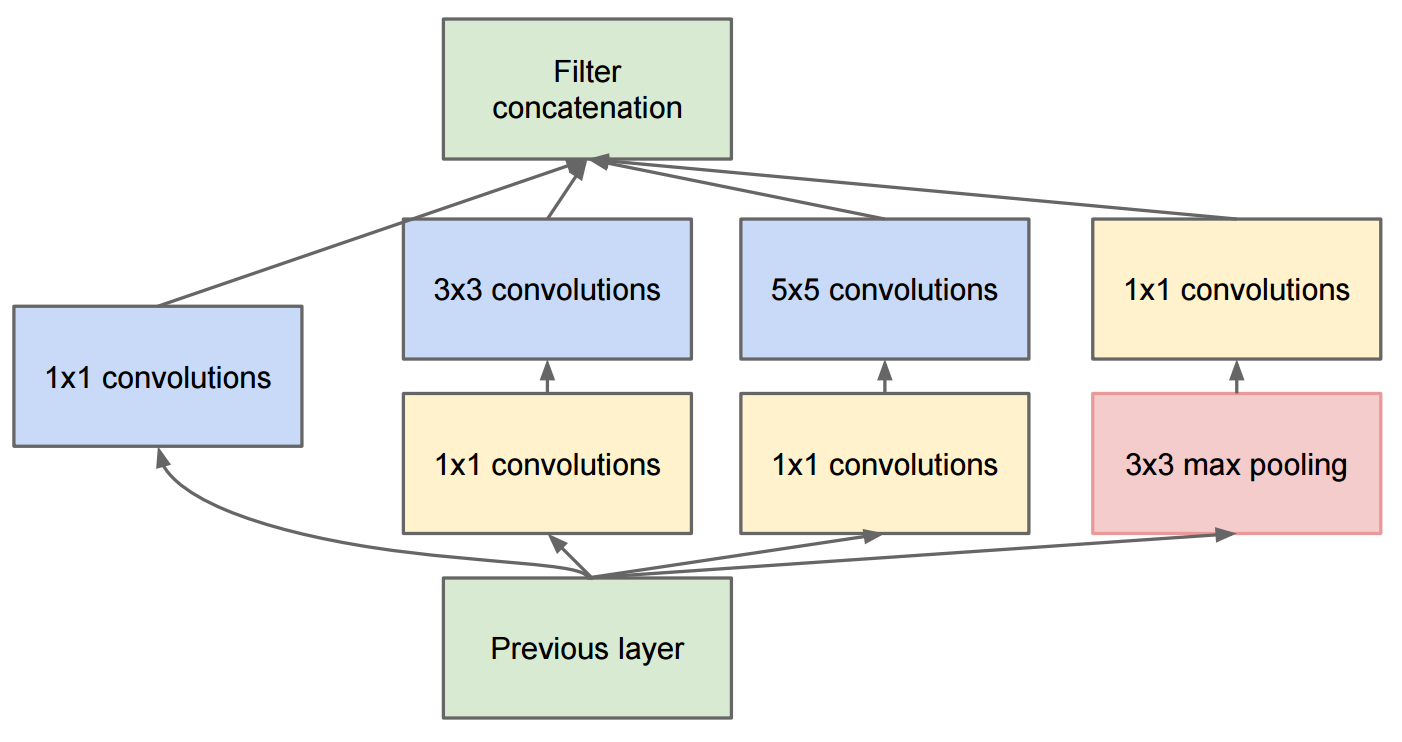

Inception Model Architecture

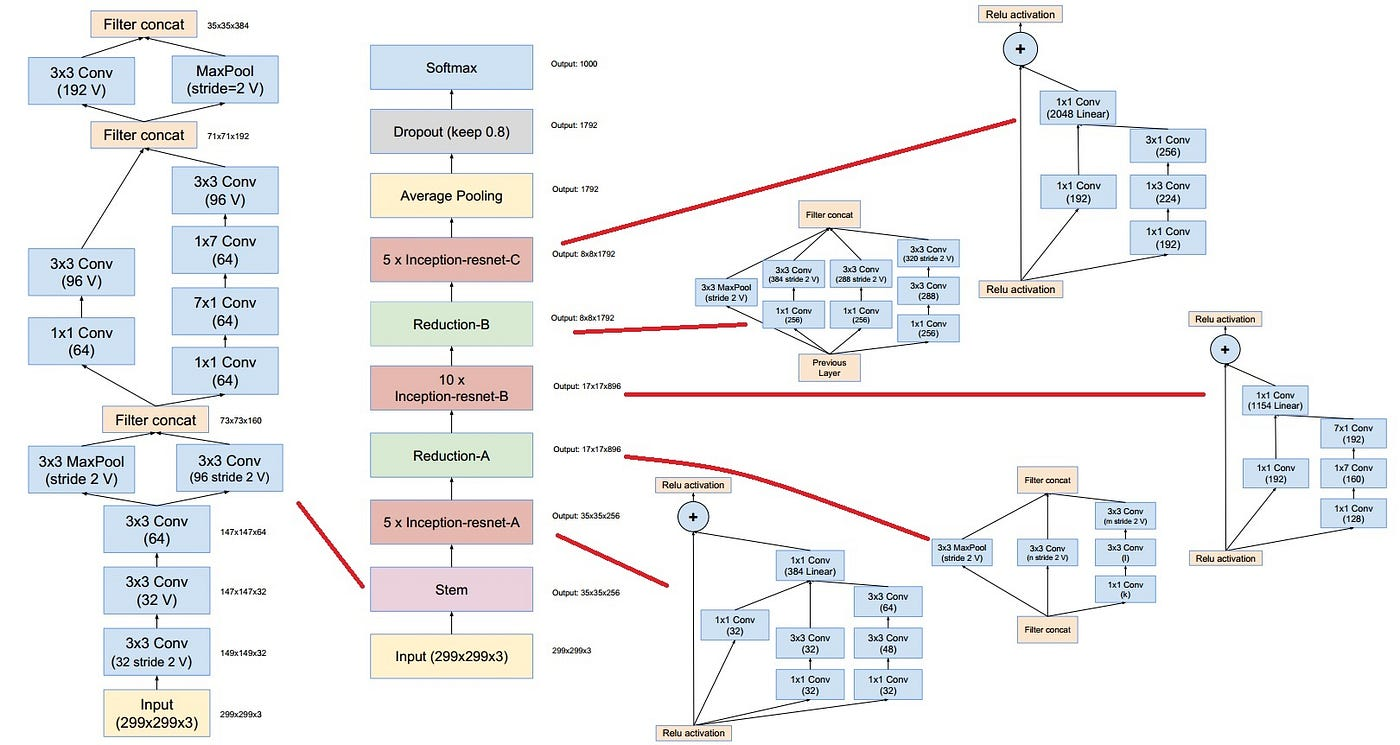

In [19]:
tf.keras.utils.plot_model(inception_model, show_shapes = True)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:359: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


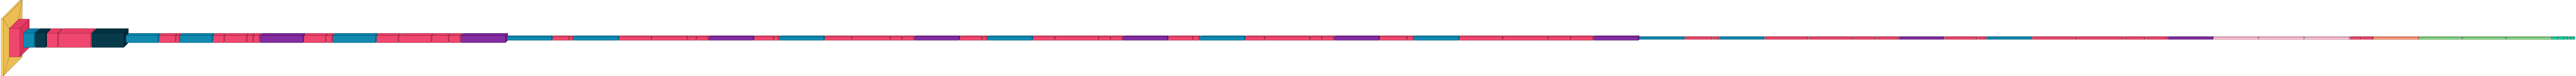

In [26]:
visualkeras.layered_view(inception_model)

In [22]:

common_metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score
]

inception_model.compile(
    optimizer='adam',
    loss={
        'main_out': 'categorical_crossentropy',
        'aux_0': 'categorical_crossentropy',
        'aux_1': 'categorical_crossentropy'
    },
    metrics={
        'main_out': common_metrics,
        'aux_0': ['accuracy'], # You can use fewer metrics for auxiliary heads to save memory
        'aux_1': ['accuracy']
    }
)

In [23]:
inception_model_history = inception_model.fit(
    train_gen_multi,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=val_gen_multi,
    validation_steps=math.ceil(validation_generator.samples / validation_generator.batch_size),
    epochs=10,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 117s 136ms/step - aux_0_accuracy: 0.5108 - aux_0_loss: 1.0969 - aux_1_accuracy: 0.4750 - aux_1_loss: 1.1266 - loss: 3.4095 - main_out_accuracy: 0.4542 - main_out_auc: 0.7332 - main_out_f1_score: 0.2568 - main_out_loss: 1.1860 - main_out_precision: 0.5583 - main_out_recall: 0.2049 - val_aux_0_accuracy: 0.4743 - val_aux_0_loss: 1.2463 - val_aux_1_accuracy: 0.4791 - val_aux_1_loss: 1.3637 - val_loss: 4.0396 - val_main_out_accuracy: 0.4888 - val_main_out_auc: 0.7627 - val_main_out_f1_score: 0.4851 - val_main_out_loss: 1.4475 - val_main_out_precision: 0.5483 - val_main_out_recall: 0.4558
Epoch 2/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - aux_0_accuracy: 0.7806 - aux_0_loss: 0.5458 - aux_1_accuracy: 0.7761 - aux_1_loss: 0.5722 - loss: 1.7266 - main_out_accuracy: 0.7673 - main_out_auc: 0.9353 - main_out_f1_score: 0.7500 - main_out_loss: 0.6087 - main_out_precision: 0.8053 - main_out_recall: 0.7071 - val_aux_0_accuracy: 0.7591 - val_aux_0_loss: 0.59

In [24]:
def create_confusion_matrix_multi(model):
  validation_generator.reset()
  # Get true labels
  true_classes = validation_generator.classes
  class_labels = list(validation_generator.class_indices.keys())

  # Get predictions from the model
  titles = ["Confusion Matrix for Main Output", "Confusion Matrix for the first side output", "Confusion Matrix for the second side output"]
  predictions = model.predict(validation_generator)
  for i in range(3):
    predicted_classes = np.argmax(predictions[i], axis=1)
    # Creating confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(titles[i])
    plt.show()




/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step


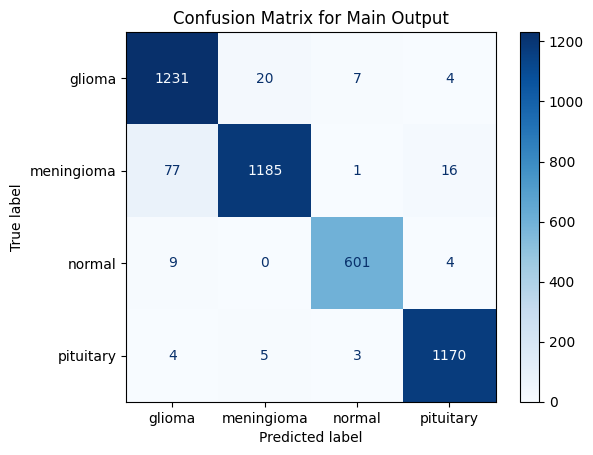

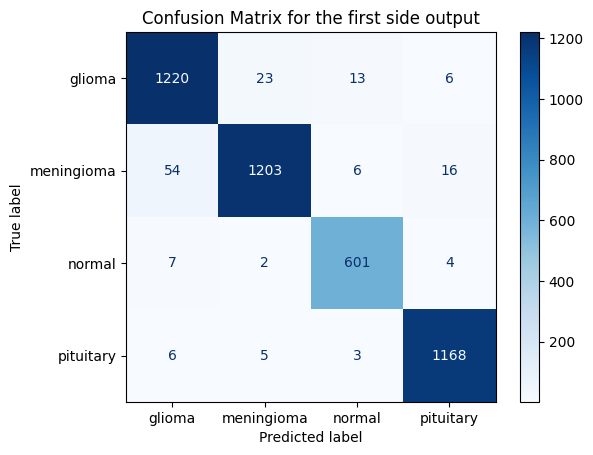

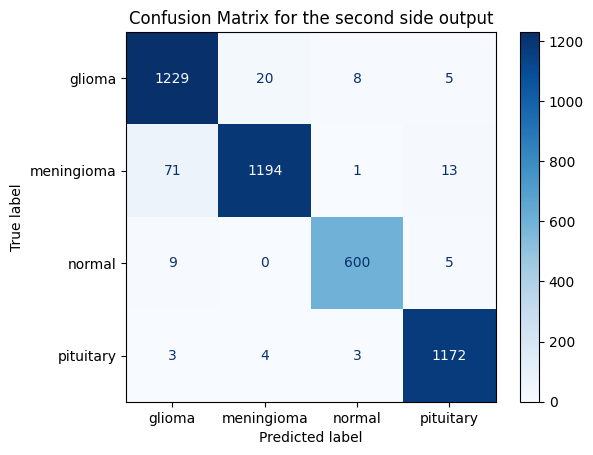

In [25]:
create_confusion_matrix_multi(inception_model)

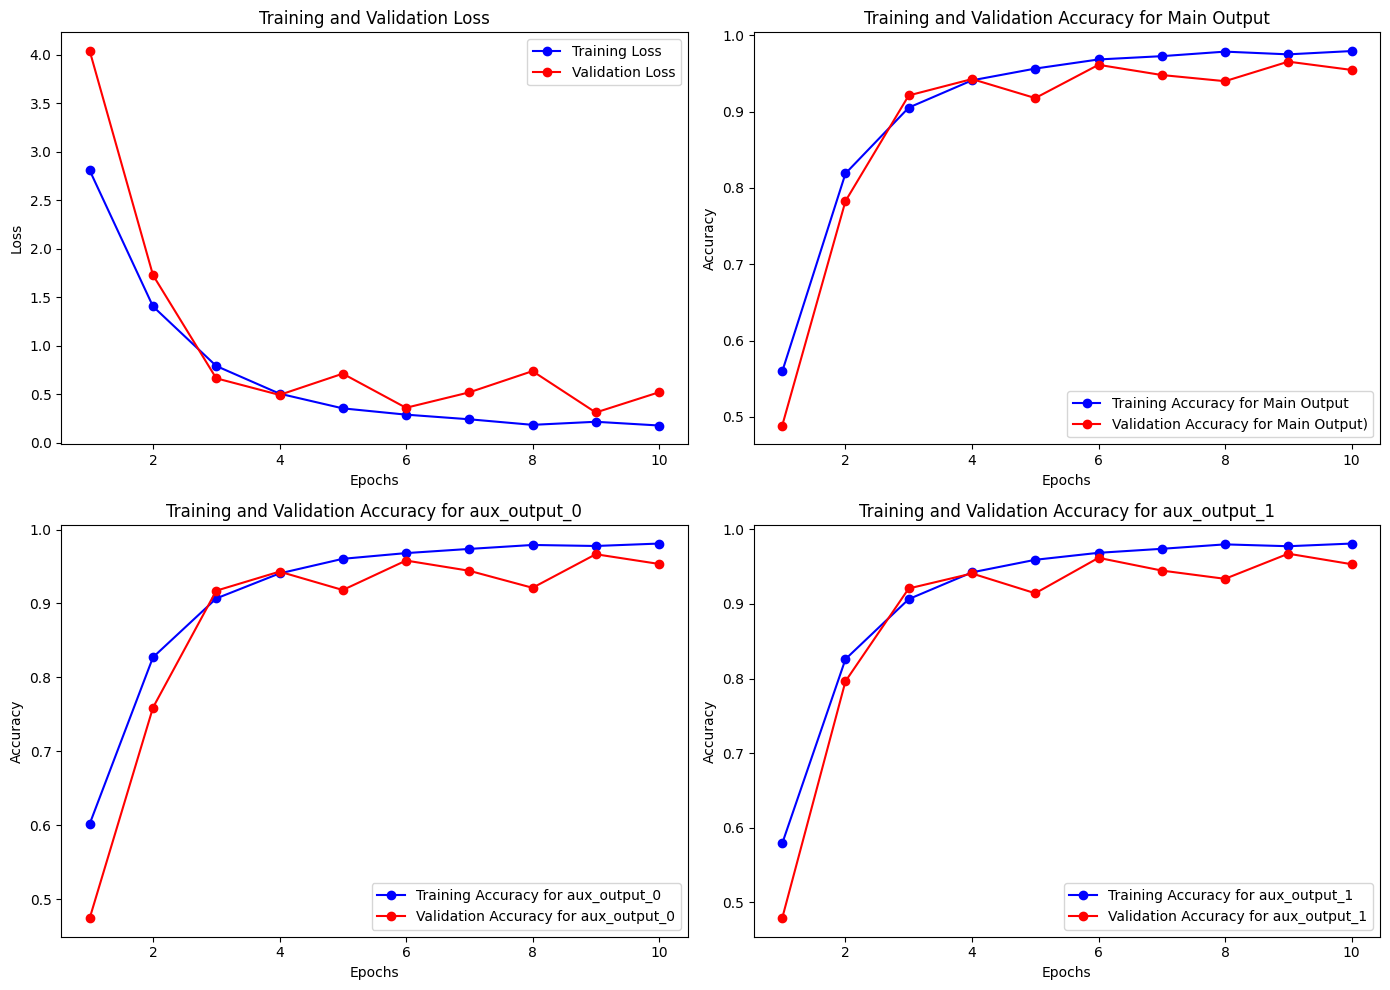

In [28]:
import matplotlib.pyplot as plt

# Data from the model history
train_loss = inception_model_history.history['loss']
train_acc_main = inception_model_history.history['main_out_accuracy']
train_acc_aux_0 = inception_model_history.history['aux_0_accuracy']
train_acc_aux_1 = inception_model_history.history['aux_1_accuracy']

val_loss = inception_model_history.history['val_loss']
val_acc_main = inception_model_history.history['val_main_out_accuracy']
val_acc_aux_0 = inception_model_history.history['val_aux_0_accuracy']
val_acc_aux_1 = inception_model_history.history['val_aux_1_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotting the figures
plt.figure(figsize=(14, 10))

# Plotting loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy for dense_4
plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_main, 'bo-', label='Training Accuracy for Main Output')
plt.plot(epochs, val_acc_main, 'ro-', label='Validation Accuracy for Main Output)')
plt.title('Training and Validation Accuracy for Main Output')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting accuracy for dense_1
plt.subplot(2, 2, 3)
plt.plot(epochs, train_acc_aux_0, 'bo-', label='Training Accuracy for aux_output_0')
plt.plot(epochs, val_acc_aux_0, 'ro-', label='Validation Accuracy for aux_output_0')
plt.title('Training and Validation Accuracy for aux_output_0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting accuracy for dense_3
plt.subplot(2, 2, 4)
plt.plot(epochs, train_acc_aux_1, 'bo-', label='Training Accuracy for aux_output_1')
plt.plot(epochs, val_acc_aux_1, 'ro-', label='Validation Accuracy for aux_output_1')
plt.title('Training and Validation Accuracy for aux_output_1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

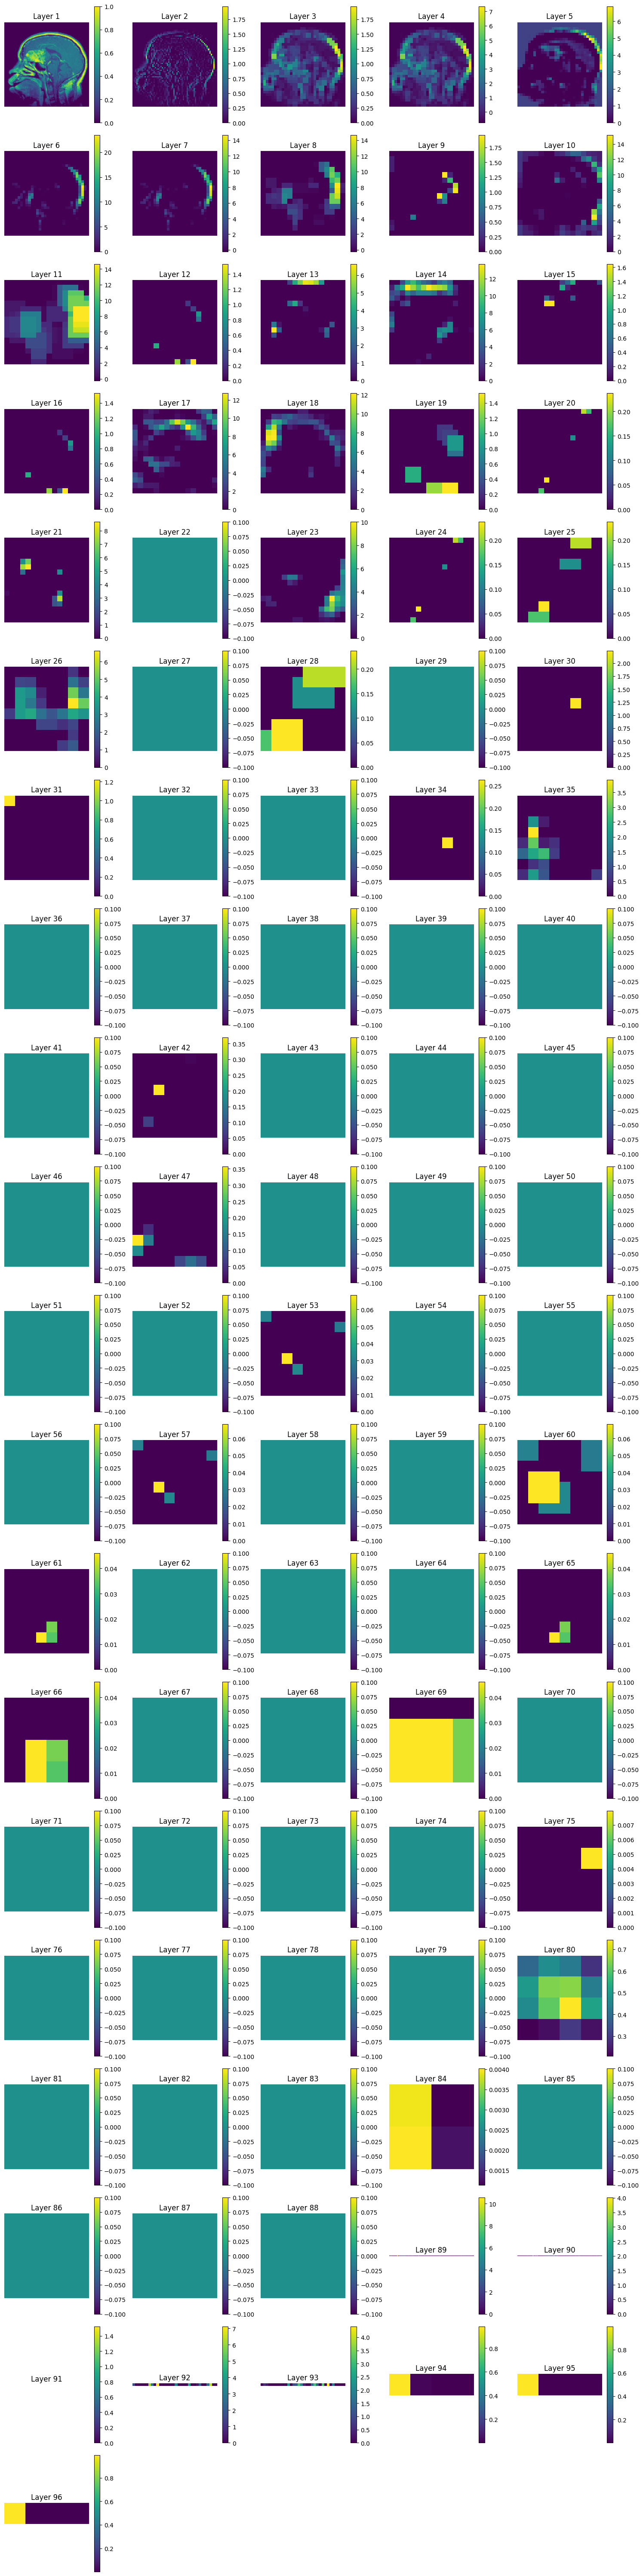

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

# Get a batch of images from the validation generator
sample_batch = next(validation_generator)
sample_image = sample_batch[0][0]  # Get the first image from the batch

# Ensure the sample image is in the correct shape
sample_image = sample_image.reshape((1, *sample_image.shape))

# Define the predict function outside the loop to avoid retracing
@tf.function
def get_intermediate_output(intermediate_model, input_data):
    return intermediate_model(input_data)

# Determine the number of layers
num_layers = len(inception_model.layers)

# Calculate the number of rows and columns for the subplots
num_cols = 5
num_rows = (num_layers // num_cols) + (1 if num_layers % num_cols != 0 else 0)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over layers
for i in range(num_layers):
    # Get the output of the current layer
    layer_output = inception_model.layers[i].output

    # Create a new model that will return the output of the current layer given an input
    intermediate_model = Model(inputs=inception_model.input, outputs=layer_output)

    # Get the output of the current layer
    intermediate_output = get_intermediate_output(intermediate_model, sample_image).numpy()

    # Handle different output shapes
    if len(intermediate_output.shape) == 4:  # For Conv2D layers
        output_image = intermediate_output[0, :, :, 0]
    elif len(intermediate_output.shape) == 2:  # For Dense layers
        output_image = intermediate_output[0].reshape((1, -1))  # Reshape to 2D for visualization
    else:
        continue  # Skip layers with unsupported output shapes

    # Visualize the output using plt.imshow
    ax = axes[i]  # Get the appropriate subplot
    ax.imshow(output_image, cmap='viridis')
    ax.set_title(f'Layer {i+1}')
    ax.axis('off')
    fig.colorbar(ax.imshow(output_image, cmap='viridis'), ax=ax)

# Hide any remaining empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
